In [32]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

Read the data 

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
news_df = pd.read_csv("/content/drive/MyDrive/archive/train.csv")

Checking for null values 

In [35]:
#removing null values
news_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [36]:
news_df=news_df.fillna(" ")

In [37]:
news_df.drop(columns = 'text',axis=1,inplace=True)

In [38]:
news_df['text'] = news_df['author'] +" "+ news_df['title']
news_df.drop(columns = ['title','author','id'],axis=1,inplace=True)

news_df.head(5)

,label,text
0,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,1,Consortiumnews.com Why the Truth Might Get You...
3,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,1,Howard Portnoy Iranian woman jailed for fictio...


Split into training and testing 

In [39]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:


stop = stopwords.words('english')
news_df['text'] = news_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
news_df.head()

,label,text
0,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,1,Consortiumnews.com Why Truth Might Get You Fired
3,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,1,Howard Portnoy Iranian woman jailed fictional ...


In [41]:
features = news_df['text']
targets = news_df['label']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [42]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

Normalizing our data: lower case, get rid of extra spaces, and url links. 

In [43]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

Convert text to vectors, our classifier only takes numerical data. 

In [44]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Apply padding so we have the same length for each article 

In [45]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Building the RNN.

In [46]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

We are going to use early stop, which stops when the validation loss no longer improve.

In [47]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
500/500 [==============================] - 48s 70ms/step - loss: 0.4570 - accuracy: 0.7188 - val_loss: 0.1198 - val_accuracy: 0.9688
Epoch 2/10
500/500 [==============================] - 20s 40ms/step - loss: 0.0713 - accuracy: 0.9795 - val_loss: 0.0520 - val_accuracy: 0.9826
Epoch 3/10
500/500 [==============================] - 19s 37ms/step - loss: 0.0280 - accuracy: 0.9938 - val_loss: 0.0684 - val_accuracy: 0.9850
Epoch 4/10
500/500 [==============================] - 18s 37ms/step - loss: 0.0150 - accuracy: 0.9975 - val_loss: 0.0728 - val_accuracy: 0.9826


Visualize our training over time 

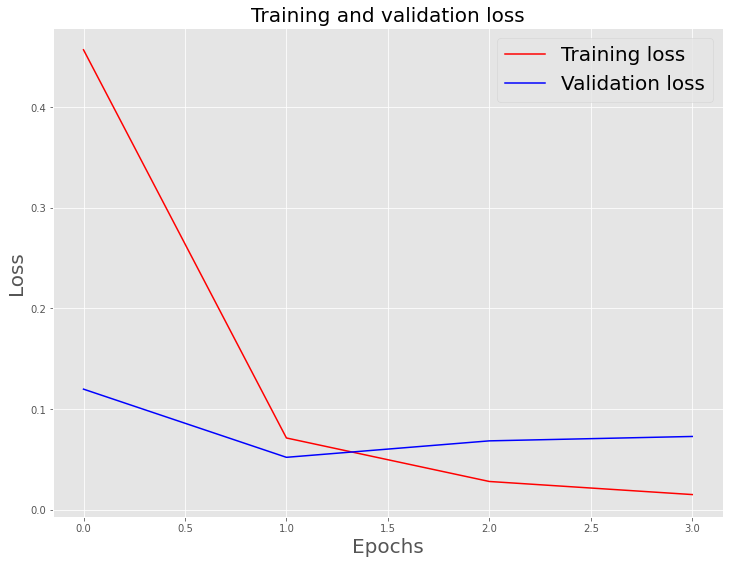

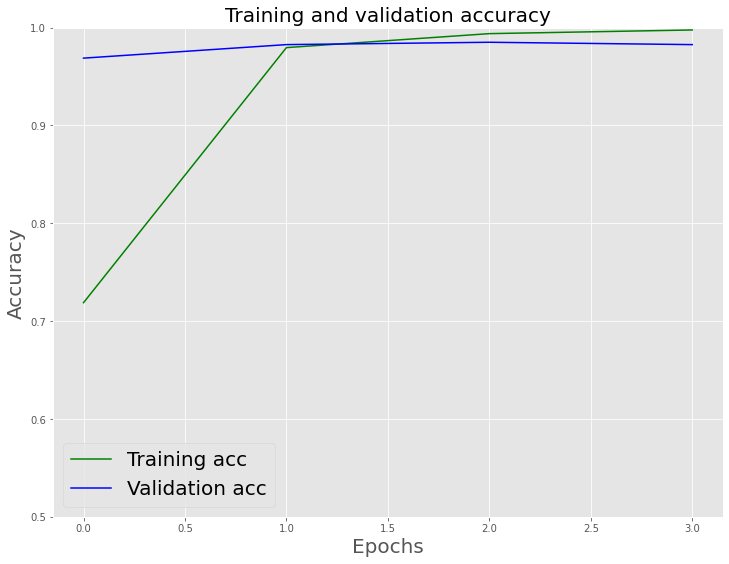

In [48]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Evaluate the testing set 

In [49]:
model.evaluate(X_test, y_test)

130/130 [==============================] - 2s 17ms/step - loss: 0.0499 - accuracy: 0.9825


[0.04990002140402794, 0.9824519157409668]

In [50]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

130/130 [==============================] - 3s 13ms/step


In [51]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9824519230769231
Precision on testing set: 0.9812859884836852
Recall on testing set: 0.9836459836459837


Confusion matrix 

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

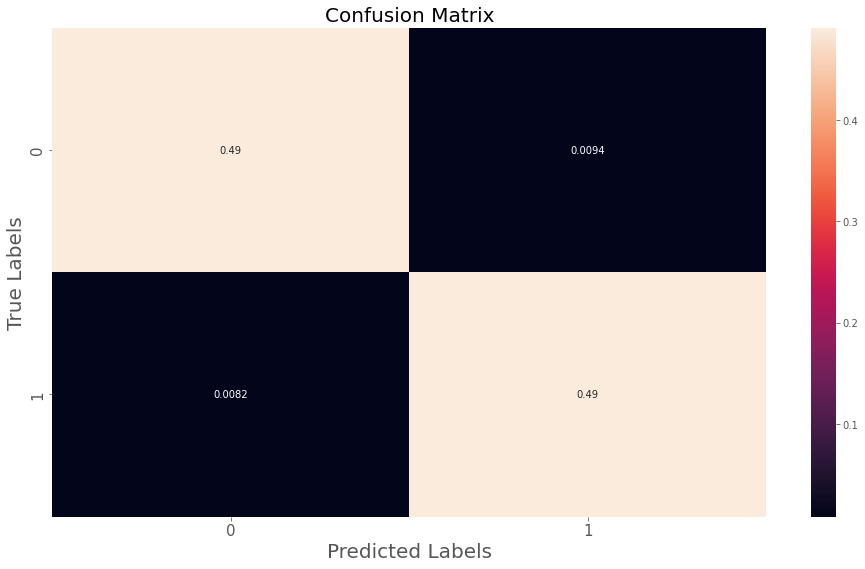

In [52]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

Saves the weights for visualiation

In [53]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [54]:
word_index = list(tokenizer.word_index.keys())
word_index = word_index[:max_vocab-1]

Write to file so we can use tensorflow's embedding projector to visualize what our network learned. This is only based on the fake news dataset. 

In [55]:
import io

out_v = io.open('fakenews_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('fakenews_meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(word_index):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [56]:
import time
import random
def avgTime(model:'Object',test_input:'numpy.ndarray') -> float:
    start = time.time()
    (model.predict(test_input)>0.5)*1
    end = time.time()
    print(avgtime:=((end-start)/(test_input.shape[0]))," s  |  ", avgtime*1000," ms  |  ", avgtime*1000000, " µs")
    return avgtime

In [57]:
#RNN Processing Time
avgTime(model, X_test)

130/130 [==============================] - 2s 13ms/step
0.00042541221930430487  s  |   0.4254122193043049  ms  |   425.41221930430487  µs


0.00042541221930430487

In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test, (model.predict(X_test))>0.5)*1)

130/130 [==============================] - 2s 14ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2076
           1       0.98      0.98      0.98      2084

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160

